## Loading Data

In [1]:
import pandas as pd
from sklearn.cross_validation import train_test_split
from sklearn.svm import SVR
import numpy as np

/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
dfFinal = pd.read_csv('News_Final.csv')
dfFb_Ec = pd.read_csv('Facebook_Economy.csv')
dfFb_Ms = pd.read_csv('Facebook_Microsoft.csv')
dfFb_Ob = pd.read_csv('Facebook_Obama.csv')
dfFb_Pa = pd.read_csv('Facebook_Palestine.csv')
dfGo_Pa = pd.read_csv('GooglePlus_Palestine.csv')
dfGo_Ob = pd.read_csv('GooglePlus_Obama.csv')
dfGo_Ms = pd.read_csv('GooglePlus_Microsoft.csv')
dfGo_Ec = pd.read_csv('GooglePlus_Economy.csv')
dfLd_Pa = pd.read_csv('LinkedIn_Palestine.csv')
dfLd_Ob = pd.read_csv('LinkedIn_Obama.csv')
dfLd_Ms = pd.read_csv('LinkedIn_Microsoft.csv')
dfLd_Ec = pd.read_csv('LinkedIn_Economy.csv')

In [ ]:
dfFb_Ec=dfFb_Ec.reset_index().T
dfFb_Ec = dfFb_Ec.drop(['index'], axis=0, inplace=False)
dfFb_Ec= dfFb_Ec.drop(['IDLink'], axis=0, inplace=False)

In [14]:
dfFb_Ec.to_csv('transformed.csv',header=None,index=False)

In [122]:
data = dfFb_Ec
# Dimensions of dataset
n = data.shape[0]
p = data.shape[1]
# Make data a numpy array
data = data.values





In [124]:
dt = dfFb_Ec[1000]
dt = dt.reshape(146,1)

In [126]:


# function to create train, validation, test data given stock data and sequence length
def split_data(cmg, seq_len):
    data_raw = cmg # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len])
    #print data
    data = np.array(data);
    valid_set_size = 20
    test_set_size = 20
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,:]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:]
    
    x_test = data[train_set_size+valid_set_size:,:-1,:]
    y_test = data[train_set_size+valid_set_size:,-1,:]
    
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]


# create train, test data
seq_len = 20 # choose sequence length
x_train, y_train, x_valid, y_valid, x_test, y_test = split_data(dt, seq_len)


print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

('x_train.shape = ', (86, 19, 1))
('y_train.shape = ', (86, 1))
('x_valid.shape = ', (20, 19, 1))
('y_valid.shape = ', (20, 1))
('x_test.shape = ', (20, 19, 1))
('y_test.shape = ', (20, 1))


In [129]:
## Basic Cell RNN in tensorflow

import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow as tf


index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

# function to get the next batch
def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size
    
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size
        
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

# parameters
n_steps = seq_len-1 
n_inputs = 1 
n_neurons = 200 
n_outputs = 1
n_layers = 2
learning_rate = 0.001
batch_size = 50
n_epochs = 500 
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

# use Basic RNN Cell
layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.elu)
          for layer in range(n_layers)]

# use Basic LSTM Cell 
#layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
#          for layer in range(n_layers)]

# use LSTM Cell with peephole connections
#layers = [tf.contrib.rnn.LSTMCell(num_units=n_neurons, 
#                                  activation=tf.nn.leaky_relu, use_peepholes = True)
#          for layer in range(n_layers)]

# use GRU cell
#layers = [tf.contrib.rnn.GRUCell(num_units=n_neurons, activation=tf.nn.leaky_relu)
#          for layer in range(n_layers)]
                                                                     
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)
                                              
# run graph
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 
            print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
                iteration*batch_size/train_set_size, mse_train, mse_valid))

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})
    

0.00 epochs: MSE train/valid = 0.947444/1.507444
4.00 epochs: MSE train/valid = 0.547861/0.163973
9.00 epochs: MSE train/valid = 0.208910/0.010775
13.00 epochs: MSE train/valid = 0.080445/0.048940
18.00 epochs: MSE train/valid = 0.088934/0.063629
23.00 epochs: MSE train/valid = 0.075066/0.031486
27.00 epochs: MSE train/valid = 0.059344/0.024614
32.00 epochs: MSE train/valid = 0.056925/0.026953
37.00 epochs: MSE train/valid = 0.051721/0.013413
41.00 epochs: MSE train/valid = 0.050311/0.005782
46.00 epochs: MSE train/valid = 0.046892/0.000001
51.00 epochs: MSE train/valid = 0.045726/0.000503
55.00 epochs: MSE train/valid = 0.043905/0.003477
60.00 epochs: MSE train/valid = 0.043279/0.002412
65.00 epochs: MSE train/valid = 0.041746/0.000527
69.00 epochs: MSE train/valid = 0.041333/0.004094
74.00 epochs: MSE train/valid = 0.039866/0.000912
79.00 epochs: MSE train/valid = 0.040249/0.004217
83.00 epochs: MSE train/valid = 0.038446/0.000457
88.00 epochs: MSE train/valid = 0.045194/0.013748
93.

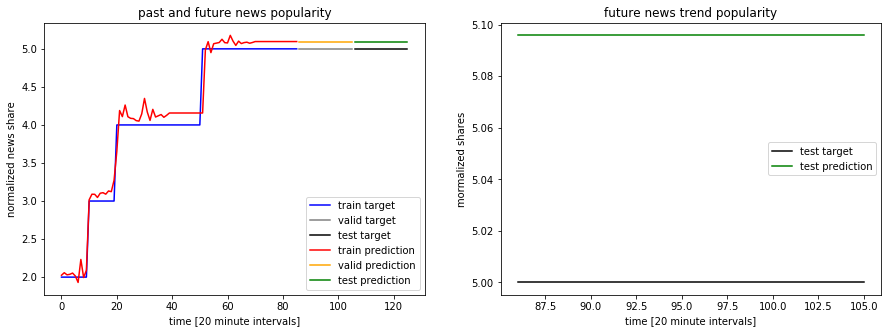

In [130]:
ft = 0 # 0 = open, 1 = close, 2 = highest, 3 = lowest

## show predictions
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);

plt.plot(np.arange(y_train.shape[0]), y_train[:,ft], color='blue', label='train target')

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_valid.shape[0]), y_valid[:,ft],
         color='gray', label='valid target')

plt.plot(np.arange(y_train.shape[0]+y_valid.shape[0],
                   y_train.shape[0]+y_test.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0]),y_train_pred[:,ft], color='red',
         label='train prediction')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_valid_pred.shape[0]),
         y_valid_pred[:,ft], color='orange', label='valid prediction')

plt.plot(np.arange(y_train_pred.shape[0]+y_valid_pred.shape[0],
                   y_train_pred.shape[0]+y_valid_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('past and future news popularity')
plt.xlabel('time [20 minute intervals]')
plt.ylabel('normalized news share')
plt.legend(loc='best');

plt.subplot(1,2,2);

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('future news trend popularity')
plt.xlabel('time [20 minute intervals]')
plt.ylabel('mormalized shares')
plt.legend(loc='best');

